In [22]:
!git clone https://github.com/time-series-foundation-models/lag-llama/
%cd /content/lag-llama
!pip install -r requirements.txt --quiet

Cloning into 'lag-llama'...
remote: Enumerating objects: 328, done.
remote: Counting objects: 100% (164/164), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 328 (delta 113), reused 107 (delta 84), pack-reused 164 (from 1)
Receiving objects: 100% (328/328), 234.57 KiB | 10.20 MiB/s, done.
Resolving deltas: 100% (155/155), done.
/content/lag-llama


In [2]:
pip install gluonts[torch]==0.14.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 12.1 MB/s eta 0:00:00
  Attempting uninstall: gluonts
    Found existing installation: gluonts 0.14.4
    Uninstalling gluonts-0.14.4:
      Successfully uninstalled gluonts-0.14.4


In [23]:
!huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir /content/lag-llama

lag-llama.ckpt: 100% 29.5M/29.5M [00:00<00:00, 89.7MB/s]
Download complete. Moving file to /content/lag-llama/lag-llama.ckpt
/content/lag-llama/lag-llama.ckpt


In [4]:
from itertools import islice

import matplotlib.dates as mdates
import pandas as pd
import torch
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.evaluation import Evaluator, make_evaluation_predictions
from lag_llama.gluon.estimator import LagLlamaEstimator
from matplotlib import pyplot as plt
from tqdm.autonotebook import tqdm

/usr/local/lib/python3.10/dist-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [5]:
def get_lag_llama_predictions(dataset, prediction_length, device, context_length=32, use_rope_scaling=False, num_samples=100):
    ckpt = torch.load("lag-llama.ckpt", map_location=device)
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    rope_scaling_arguments = {
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    }

    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        rope_scaling=rope_scaling_arguments if use_rope_scaling else None,
        batch_size=1,
        num_parallel_samples=num_samples,
        device=device,
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)

    return forecasts, tss

In [ ]:
pip install yfinance==0.2.37

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.0/73.0 kB 2.3 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.41
    Uninstalling yfinance-0.2.41:
      Successfully uninstalled yfinance-0.2.41


In [6]:
def _get_lag_llama_dataset(dataset):
    # avoid mutations
    dataset = dataset.copy()

    # convert numerical columns to `float32`
    for col in dataset.columns:
        if dataset[col].dtype != "object" and not pd.api.types.is_string_dtype(
            dataset[col]
        ):
            dataset[col] = dataset[col].astype("float32")

    # create a `PandasDataset`
    backtest_dataset = PandasDataset(dict(dataset))
    return backtest_dataset




In [7]:
import yfinance as yf
# دانلود داده‌های سهام
ticker = 'AAPL'  # به عنوان مثال: Apple Inc.
stock_returns = yf.download(ticker, start="2000-01-01", end="2024-01-01")['Close'].resample('1D').ffill()
stock_returns

[*********************100%%**********************]  1 of 1 completed


,Close
Date,
2000-01-03,0.999442
2000-01-04,0.915179
2000-01-05,0.928571
2000-01-06,0.848214
2000-01-07,0.888393
...,...
2023-12-25,193.600006
2023-12-26,193.050003
2023-12-27,193.149994


In [8]:
device = torch.device("cuda:0")
import numpy as np

In [9]:
context_lengths = range(32, 513, 32)

In [24]:
from tqdm import tqdm
import numpy as np
import pandas as pd

# لیستی از context_len های مختلف برای آزمایش (باید مضرب 32 باشد)
results_by_context_len = []

# تنظیم تاریخ شروع برای پیش‌بینی
start_date = pd.to_datetime("2023-03-08")

# ثابت نگه‌داشتن مقادیر
prediction_length = 1
batch_size = 1

# حلقه برای آزمایش اندازه‌های مختلف context_len
for context_len in context_lengths:
    print(f"Processing context_len: {context_len}")
    start_idx = stock_returns.index.get_loc(start_date) - context_len

    # حلقه برای پیش‌بینی‌های روزانه تا زمانی که به انتهای داده‌ها برسد
    while start_idx + context_len +1  < len(stock_returns):
        # تعیین بازه زمانی ورودی
        end_idx = start_idx + context_len+1

        # آماده‌سازی داده‌های ورودی
        input_data = stock_returns[start_idx:end_idx].to_frame()
        backtest_dataset = _get_lag_llama_dataset(input_data)
        forecasts, _ = get_lag_llama_predictions(backtest_dataset, prediction_length, device, context_len, use_rope_scaling=False, num_samples=100)

        # ذخیره نتیجه در لیست نتایج
        result = {
            'input_index': start_idx + context_len,
            'train_start_date': input_data.index[0],
            'train_end_date': input_data.index[-2],
            'predict_date': input_data.index[-1],
            'raw_forecast': np.mean(forecasts[0].samples),
            'y_actual': stock_returns[input_data.index[-1]],
            'context_len': context_len,
        }
        results_by_context_len.append(result)

        # به روز رسانی start_idx برای روز بعد
        start_idx += 1

# تبدیل نتایج به DataFrame
results_df = pd.DataFrame(results_by_context_len)
results_df


Processing context_len: 32
Processing context_len: 64
Processing context_len: 96
Processing context_len: 128
Processing context_len: 160
Processing context_len: 192
Processing context_len: 224
Processing context_len: 256
Processing context_len: 288
Processing context_len: 320
Processing context_len: 352
Processing context_len: 384
Processing context_len: 416
Processing context_len: 448
Processing context_len: 480
Processing context_len: 512


,input_index,train_start_date,train_end_date,predict_date,raw_forecast,y_actual,context_len
0,8465,2023-02-04,2023-03-07,2023-03-08,155.506454,152.869995,32
1,8466,2023-02-05,2023-03-08,2023-03-09,149.903870,150.589996,32
2,8467,2023-02-06,2023-03-09,2023-03-10,149.425949,148.500000,32
3,8468,2023-02-07,2023-03-10,2023-03-11,153.404419,148.500000,32
4,8469,2023-02-08,2023-03-11,2023-03-12,152.559021,148.500000,32
...,...,...,...,...,...,...,...
4731,8756,2022-07-30,2023-12-23,2023-12-24,205.181488,193.600006,512
4732,8757,2022-07-31,2023-12-24,2023-12-25,204.759369,193.600006,512
4733,8758,2022-08-01,2023-12-25,2023-12-26,204.688354,193.050003,512
4734,8759,2022-08-02,2023-12-26,2023-12-27,205.993805,193.149994,512


In [25]:
# تبدیل نتایج به DataFrame
results_df = pd.DataFrame(results_by_context_len)

# ذخیره DataFrame به صورت pickle
results_df.to_pickle('results_by_context_len.pkl')

print("DataFrame successfully saved as pickle file.")


DataFrame successfully saved as pickle file.


In [ ]:
import pandas as pd

# خواندن فایل pickle و ذخیره در متغیر results
results = pd.read_pickle('results_by_context_len.pkl')

# نمایش موفقیت‌آمیز بودن عملیات
print("DataFrame successfully loaded into 'results'.")


DataFrame successfully loaded into 'results'.


In [26]:
import pandas as pd
from sklearn.metrics import mean_squared_error, accuracy_score

def calculate_mse(context_results_df):
    return mean_squared_error(context_results_df['y_actual'], context_results_df['raw_forecast'])

def calculate_accuracy(context_results_df):
    correct_predictions = 0
    total_predictions = 0
    for i in range(1, len(context_results_df)):
        actual_today = context_results_df['y_actual'].iloc[i]
        predicted_today = context_results_df['raw_forecast'].iloc[i]
        actual_yesterday = context_results_df['y_actual'].iloc[i - 1]
        actual_movement = actual_today - actual_yesterday
        predicted_movement = predicted_today - actual_yesterday
        if (actual_movement > 0 and predicted_movement > 0) or (actual_movement < 0 and predicted_movement < 0):
            correct_predictions += 1
        total_predictions += 1
    return correct_predictions / total_predictions if total_predictions > 0 else 0

def calculate_profit(context_results_df, initial_capital=100):
    capital = initial_capital
    position = 0

    for i in range(1, len(context_results_df)):
        today_price = context_results_df['y_actual'].iloc[i]
        yesterday_price = context_results_df['y_actual'].iloc[i - 1]
        predicted_today_price = context_results_df['raw_forecast'].iloc[i]

        if predicted_today_price > yesterday_price:
            if position == 0:
                position = capital / yesterday_price
                capital = 0
        elif predicted_today_price < yesterday_price:
            if position > 0:
                capital = position * yesterday_price
                position = 0

    if position > 0:
        capital = position * context_results_df.iloc[-1]['y_actual']

    return capital - initial_capital

def calculate_actual_direction_accuracy(context_results_df):
    def get_direction(current_price, next_price):
        return 1 if next_price > current_price else 0

    real_directions = []
    predicted_directions = []

    for i in range(1, len(context_results_df)):
        real_directions.append(get_direction(context_results_df['y_actual'].iloc[i - 1], context_results_df['y_actual'].iloc[i]))
        predicted_directions.append(get_direction(context_results_df['y_actual'].iloc[i - 1], context_results_df['raw_forecast'].iloc[i]))

    return accuracy_score(real_directions, predicted_directions)

def calculate_direction_accuracy(context_results_df):
    def get_direction(current_price, next_price):
        return 1 if next_price > current_price else 0

    real_directions = []
    predicted_directions = []

    for i in range(1, len(context_results_df)):
        real_directions.append(get_direction(context_results_df['y_actual'].iloc[i - 1], context_results_df['y_actual'].iloc[i]))
        predicted_directions.append(get_direction(context_results_df['raw_forecast'].iloc[i - 1], context_results_df['raw_forecast'].iloc[i]))

    return accuracy_score(real_directions, predicted_directions)

def calculate_direction_profit(context_results_df, initial_capital=100):
    capital = initial_capital
    position = 0

    for i in range(2, len(context_results_df)):
        yesterday_price = context_results_df['y_actual'].iloc[i - 1]
        yesterday_predicted_today_price = context_results_df['raw_forecast'].iloc[i - 1]
        predicted_today_price = context_results_df['raw_forecast'].iloc[i]

        if predicted_today_price > yesterday_predicted_today_price:
            if position == 0:
                position = capital / yesterday_price
                capital = 0
        elif predicted_today_price < yesterday_predicted_today_price:
            if position > 0:
                capital = position * yesterday_price
                position = 0

    if position > 0:
        capital = position * context_results_df.iloc[-1]['y_actual']

    return  capital - initial_capital

def calculate_final_results(context_lengths, results_by_context_len):
    final_results = []

    for context_len in context_lengths:

        context_results_df = pd.DataFrame([res for res in results_by_context_len if res['context_len'] == context_len])
        if len(context_results_df) == 0:
            print(f"No data available for context_len = {context_len}. Skipping this context_len.")
            continue

        mse_value = calculate_mse(context_results_df)
        accuracy_value = calculate_accuracy(context_results_df)
        profit = calculate_profit(context_results_df)
        direction_accuracy = calculate_direction_accuracy(context_results_df)
        actual_direction_accuracy = calculate_actual_direction_accuracy(context_results_df)
        direction_profit = calculate_direction_profit(context_results_df)

        final_results.append({
            'context_len': context_len,
            'mse': mse_value,
            'accuracy': accuracy_value,
            'direction_accuracy': direction_accuracy,
            'actual_direction_accuracy': actual_direction_accuracy,
            'direction_profit': direction_profit,
            'profit': profit
        })

    return pd.DataFrame(final_results)




In [27]:
results_by_context_len = results_df.to_dict(orient='records')

final_result=calculate_final_results(context_lengths,results_by_context_len)
final_result

,context_len,mse,accuracy,direction_accuracy,actual_direction_accuracy,direction_profit,profit
0,32,60.182271,0.372881,0.467797,0.589831,8.310351,20.640060
1,64,142.645465,0.355932,0.457627,0.583051,4.133218,4.028386
2,96,172.912302,0.359322,0.518644,0.596610,24.999183,9.522932
3,128,244.834360,0.349153,0.440678,0.593220,15.525024,5.393316
4,160,237.114367,0.338983,0.454237,0.606780,-10.081619,5.335447
5,192,64.260466,0.335593,0.491525,0.562712,7.016271,-2.733095
6,224,81.168380,0.355932,0.488136,0.583051,22.892004,11.165413
7,256,90.525150,0.338983,0.498305,0.576271,11.209524,3.778421
8,288,83.138754,0.349153,0.528814,0.603390,27.422146,8.094005
9,320,92.156659,0.325424,0.511864,0.596610,17.909814,5.279340


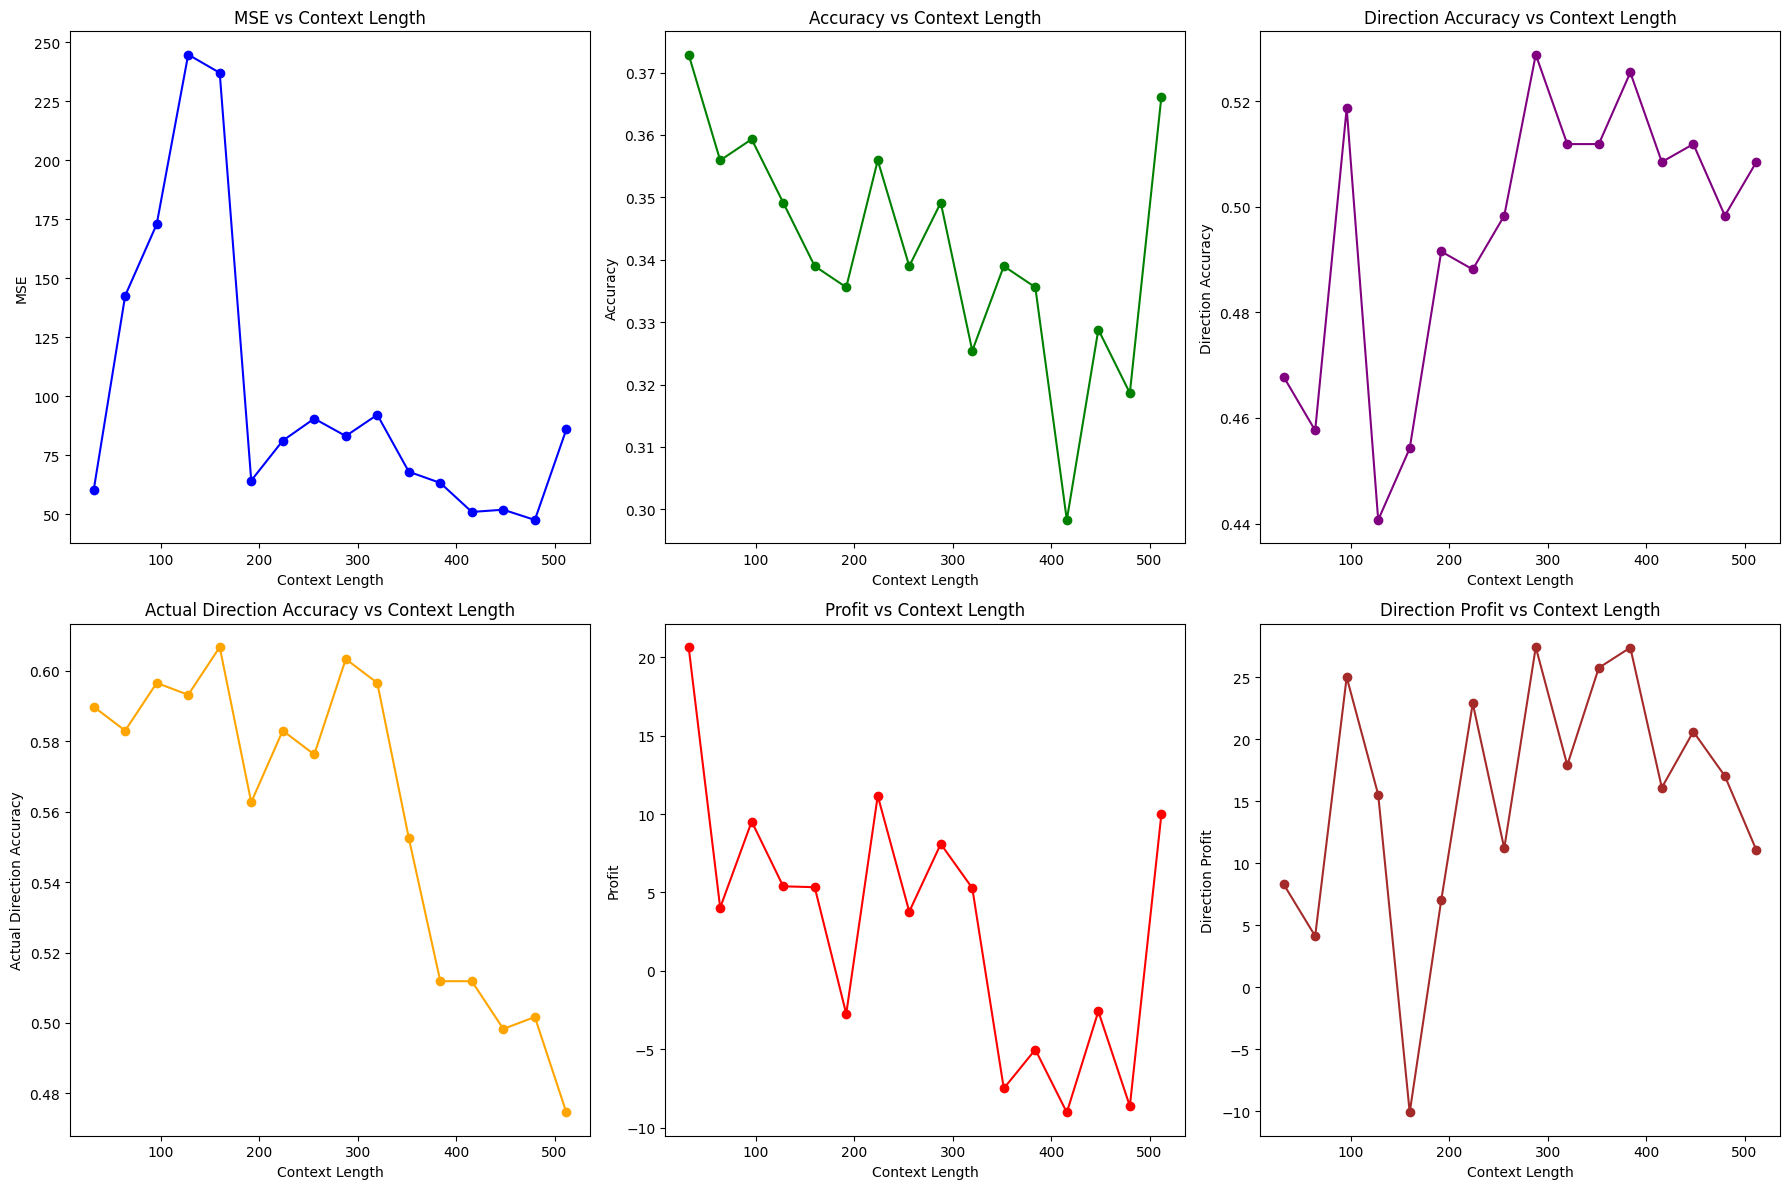

In [28]:
import matplotlib.pyplot as plt

# رسم نمودار تغییرات MSE، Accuracy، Direction Accuracy، Actual Direction Accuracy، Profit و Direction Profit بر حسب context_len
plt.figure(figsize=(18, 12))

# نمودار MSE
plt.subplot(2, 3, 1)
plt.plot(final_result['context_len'], final_result['mse'], marker='o', color='blue')
plt.title('MSE vs Context Length')
plt.xlabel('Context Length')
plt.ylabel('MSE')

# نمودار Accuracy
plt.subplot(2, 3, 2)
plt.plot(final_result['context_len'], final_result['accuracy'], marker='o', color='green')
plt.title('Accuracy vs Context Length')
plt.xlabel('Context Length')
plt.ylabel('Accuracy')

# نمودار Direction Accuracy
plt.subplot(2, 3, 3)
plt.plot(final_result['context_len'], final_result['direction_accuracy'], marker='o', color='purple')
plt.title('Direction Accuracy vs Context Length')
plt.xlabel('Context Length')
plt.ylabel('Direction Accuracy')

# نمودار Actual Direction Accuracy
plt.subplot(2, 3, 4)
plt.plot(final_result['context_len'], final_result['actual_direction_accuracy'], marker='o', color='orange')
plt.title('Actual Direction Accuracy vs Context Length')
plt.xlabel('Context Length')
plt.ylabel('Actual Direction Accuracy')

# نمودار Profit
plt.subplot(2, 3, 5)
plt.plot(final_result['context_len'], final_result['profit'], marker='o', color='red')
plt.title('Profit vs Context Length')
plt.xlabel('Context Length')
plt.ylabel('Profit')

# نمودار Direction Profit
plt.subplot(2, 3, 6)
plt.plot(final_result['context_len'], final_result['direction_profit'], marker='o', color='brown')
plt.title('Direction Profit vs Context Length')
plt.xlabel('Context Length')
plt.ylabel('Direction Profit')

plt.tight_layout()
plt.show()


In [29]:
# پیدا کردن context_len که بیشترین مقدار هر معیار را دارد

# MSE
min_mse = final_result.loc[final_result['mse'].idxmin()]
print(f"Minimum MSE: {min_mse['mse']} at Context Length: {min_mse['context_len']}")

# Accuracy
max_accuracy = final_result.loc[final_result['accuracy'].idxmax()]
print(f"Maximum Accuracy: {max_accuracy['accuracy']} at Context Length: {max_accuracy['context_len']}")

# Direction Accuracy
max_direction_accuracy = final_result.loc[final_result['direction_accuracy'].idxmax()]
print(f"Maximum Direction Accuracy: {max_direction_accuracy['direction_accuracy']} at Context Length: {max_direction_accuracy['context_len']}")

# Actual Direction Accuracy
max_actual_direction_accuracy = final_result.loc[final_result['actual_direction_accuracy'].idxmax()]
print(f"Maximum Actual Direction Accuracy: {max_actual_direction_accuracy['actual_direction_accuracy']} at Context Length: {max_actual_direction_accuracy['context_len']}")

# Profit
max_profit = final_result.loc[final_result['profit'].idxmax()]
print(f"Maximum Profit: {max_profit['profit']} at Context Length: {max_profit['context_len']}")

# Direction Profit
max_direction_profit = final_result.loc[final_result['direction_profit'].idxmax()]
print(f"Maximum Direction Profit: {max_direction_profit['direction_profit']} at Context Length: {max_direction_profit['context_len']}")


Minimum MSE: 47.56377273957666 at Context Length: 480.0
Maximum Accuracy: 0.3728813559322034 at Context Length: 32.0
Maximum Direction Accuracy: 0.5288135593220339 at Context Length: 288.0
Maximum Actual Direction Accuracy: 0.6067796610169491 at Context Length: 160.0
Maximum Profit: 20.64005971334265 at Context Length: 32.0
Maximum Direction Profit: 27.422146062895223 at Context Length: 288.0


In [30]:
initial_investment = 100
initial_price = results_df['y_actual'].iloc[0]
final_price = results_df['y_actual'].iloc[-1]


# Calculate the number of shares bought initially
shares_bought = initial_investment / initial_price

# Calculate the final value of the investment
final_investment_value = shares_bought * final_price

# Calculate the total profit
buy_and_hold_profit = final_investment_value - initial_investment
buy_and_hold_profit

26.630475576753682